In [7]:
import sys, os
import numpy as np
from tqdm import tqdm
import random

local_path = '\\Users\\frank\\Online dictionnary learning spard coding\\Online-Dictionary-Learning-for-Sparse-Coding'
sys.path.append(local_path)

%load_ext autoreload
%autoreload 2
from src.Visualization.Audio import AudioVisualizer
from src.Evalution.Reconstruction import Evaluation
from src.Dataset.Audioselection import AudioPreprocessor
from src.Model.Audio_model import DictionaryLearner, DictionaryVisualizer
from src.Dataset.Noise import NoiseAdder

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Signal Reconstruction : Reconstruct a signal which was part on train set

### Select video and preprocess them to learn the dictionnary

In [8]:
directory_path = 'C:\\Users\\frank\\Online dictionnary learning spard coding\\data\\cv-corpus-15.0-delta-2023-09-08\\en\\clips'
num_samples = 100 # Number of audio files to select

preprocessor = AudioPreprocessor(directory_path, num_samples, target_duration=3)
preprocessed_audios = preprocessor.preprocess_all()


### Use gridsearch to find suitable parameters

In [9]:
def calculate_dtw_error(original_signal, reconstructed_signal):
    alignment = np.linalg.norm(original_signal - reconstructed_signal)
    return alignment

In [10]:
param_grid = {
    'n_components': [ 30, 40, 50],
    'alpha': [1, 2, 5 ,8],
    'batch_size': [3, 5, 10, 15, 20]
}


In [13]:
best_params = None
best_error = float('inf')

# Iterating over the parameter grid
for n_components in tqdm(param_grid['n_components']):
    for alpha in param_grid['alpha']:
            for batch_size in param_grid['batch_size']:
                # Initialize and train the DictionaryLearner
                learner = DictionaryLearner(n_components=n_components, alpha=alpha, max_iter= 2000, batch_size=batch_size)
                dictionary = learner.fit(preprocessed_audios)

                # Evaluate the dictionary using DTW error
                evaluator = Evaluation(dictionary)
                total_error = 0
                for signal in preprocessed_audios:
                    reconstructed_signal = evaluator.reconstruct_signal(signal)
                    total_error += calculate_dtw_error(signal, reconstructed_signal)

                avg_error = total_error / len(preprocessed_audios)

                
                # Update best parameters
                if avg_error < best_error:
                    best_error = avg_error
                    best_params = {'n_components': n_components, 'alpha': alpha,  'batch_size': batch_size}

print(f"Best Parameters: {best_params}, Best Error: {best_error}")


  0%|          | 0/3 [00:00<?, ?it/s]C:\Users\frank\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=1.702e-06, previous alpha=1.702e-06, with an active set of 6 regressors.
  warnings.warn(
 67%|██████▋   | 2/3 [21:09<11:29, 689.70s/it]C:\Users\frank\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=1.720e-06, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
C:\Users\frank\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_least_angle.py:645: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after

Best Parameters: {'n_components': 50, 'alpha': 1, 'batch_size': 3}, Best Error: 15.150465828180312


In [14]:
print(f"The best parameters are {best_params}")
print(f"The corresponding L2 norm between the reconstructed and original signals is {best_error}")

The best parameters are {'n_components': 50, 'alpha': 1, 'batch_size': 3}
The corresponding L2 norm between the reconstructed and original signals is 15.150465828180312


### use those parameters to learn dictionnary

In [15]:
learner = DictionaryLearner(n_components=best_params["n_components"], alpha=best_params["alpha"], max_iter=2000,
                             batch_size= best_params["batch_size"])
dictionary = learner.fit(preprocessed_audios)



#### Display some atoms, you can view all of them if you want, it just makes the notebook too long

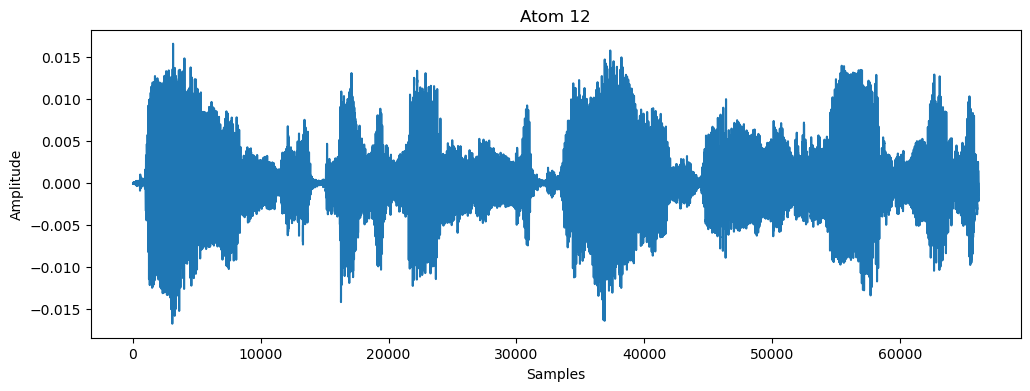

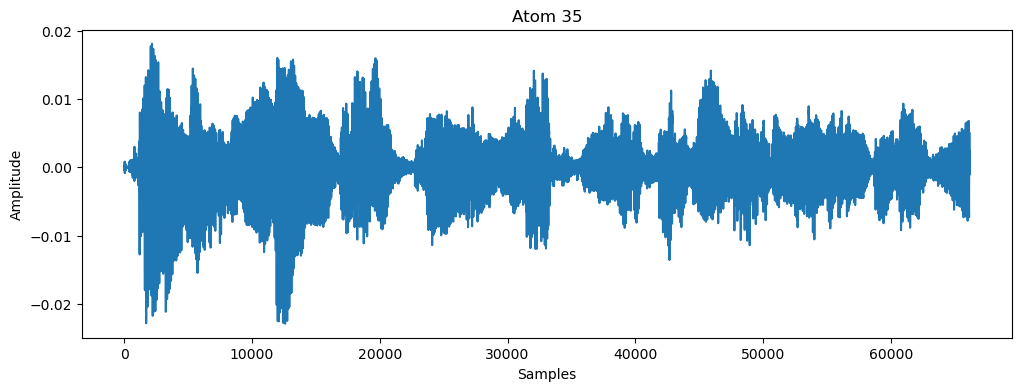

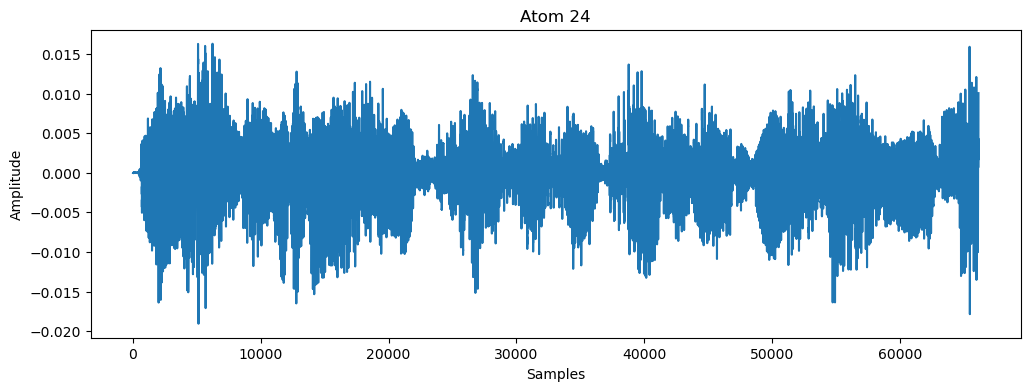

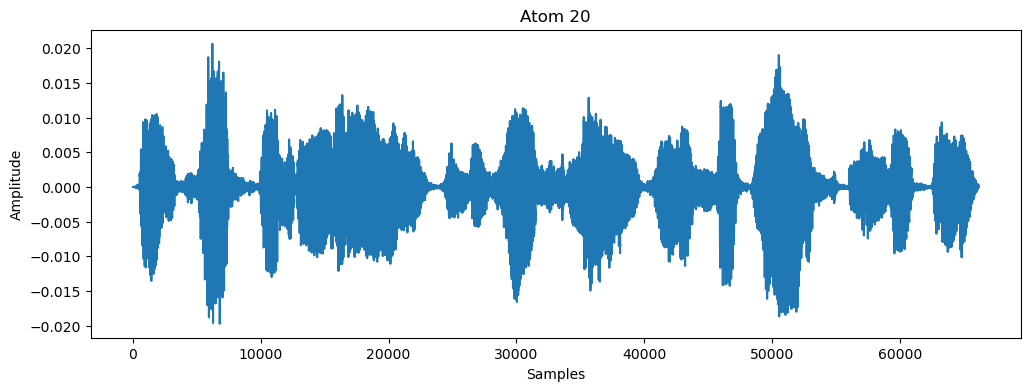

In [18]:
number_dic = 4
visualizer = DictionaryVisualizer(dictionary, sample_rate=22050, number_dic = number_dic)
visualizer.show_all_atoms()

In [23]:

Reconstructor = Evaluation(dictionary)
best_signal_reconstruted = []

for i in range(len(preprocessed_audios)):
   reconstructed_signal = Reconstructor.reconstruct_signal(preprocessed_audios[i])
   distance = calculate_dtw_error(preprocessed_audios[i], reconstructed_signal)
   if distance <  3: 
      best_signal_reconstruted.append(i)

C:\Users\frank\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 27 iterations, alpha=2.415e-06, previous alpha=2.415e-06, with an active set of 24 regressors.
  warnings.warn(
C:\Users\frank\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_least_angle.py:675: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 42 iterations, alpha=1.718e-06, previous alpha=1.718e-06, with an active set of 31 regressors.
  warnings.warn(


### Reconstruction of signal which was part off train set.
You can visualyse all of them and all the atoms to see that the dictionnary did'nt just memory those specifique signals 

The original signal 86


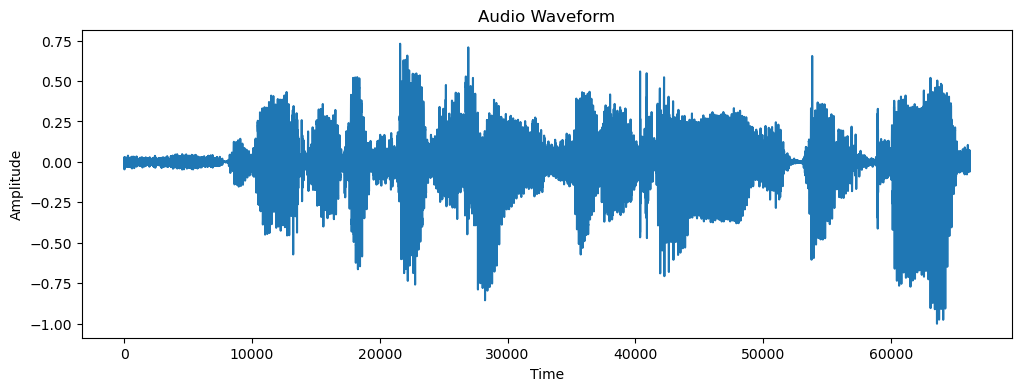

The reconstruction version of 86


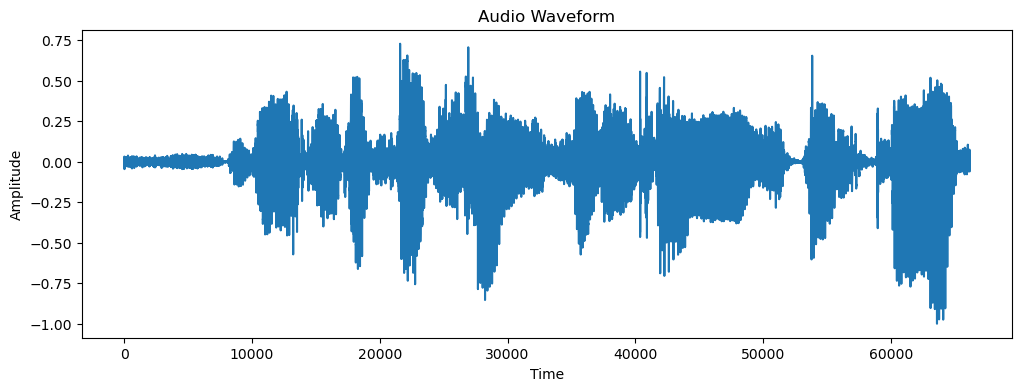



The original signal 45


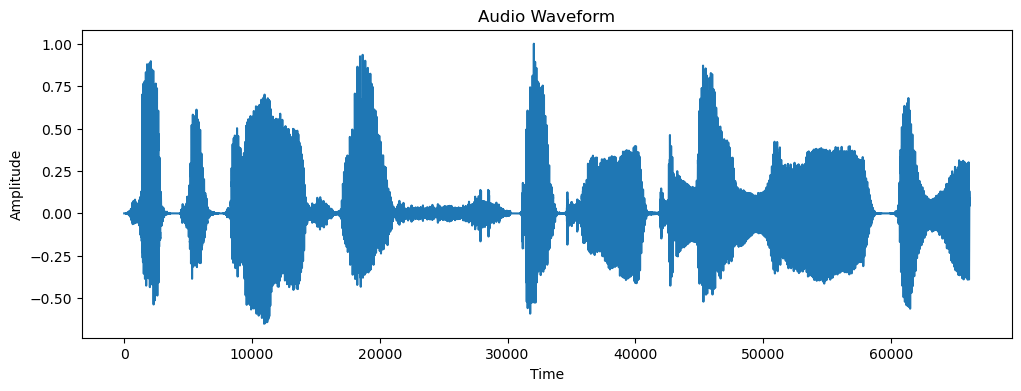

The reconstruction version of 45


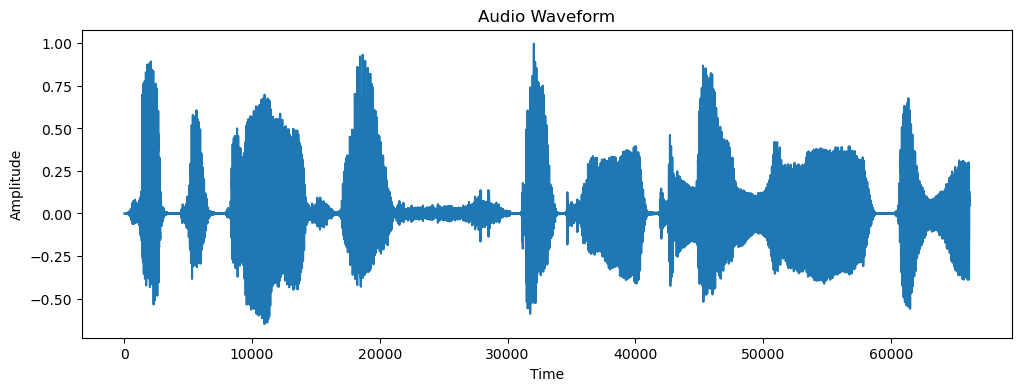



The original signal 15


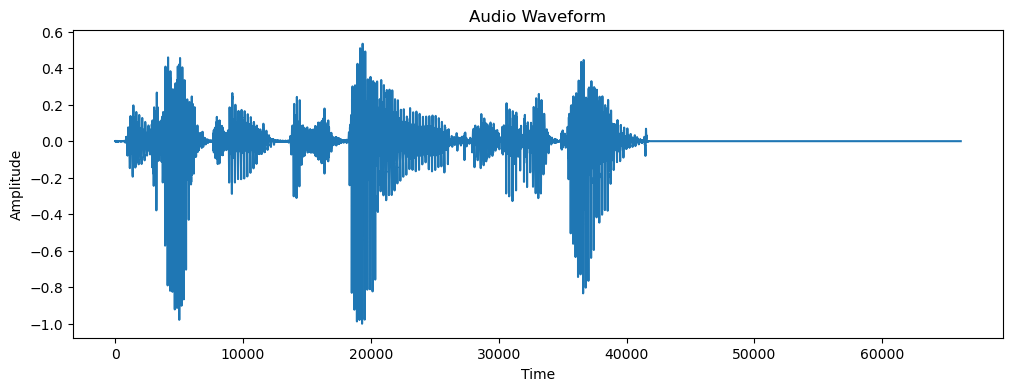

The reconstruction version of 15


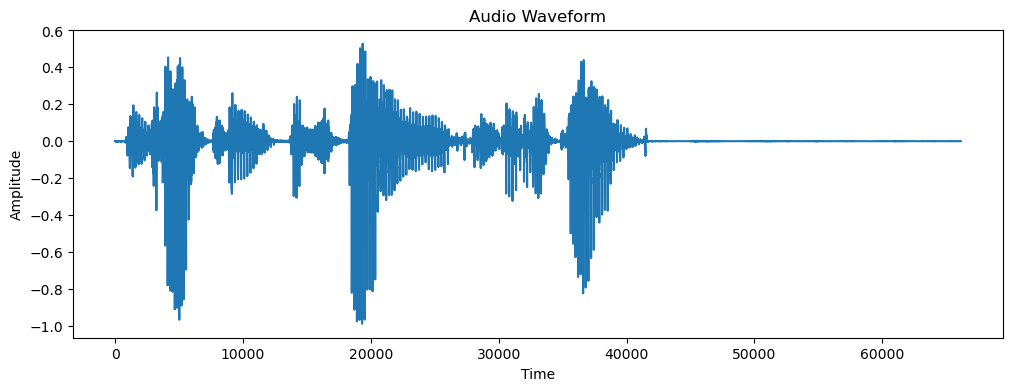



The original signal 70


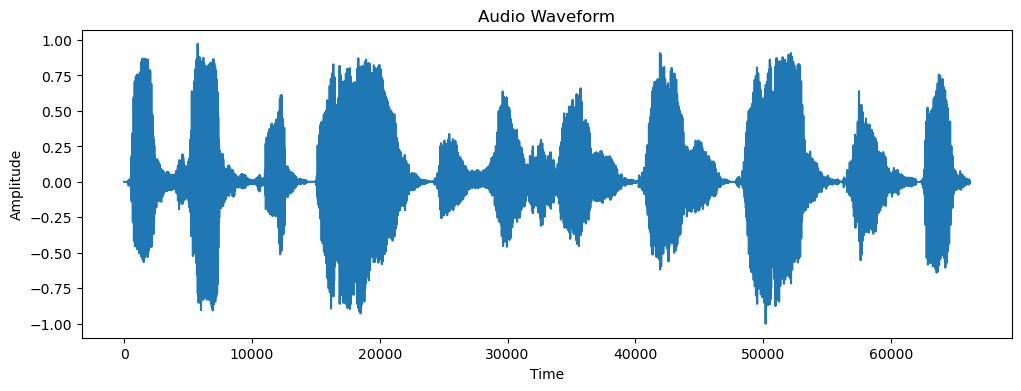

The reconstruction version of 70


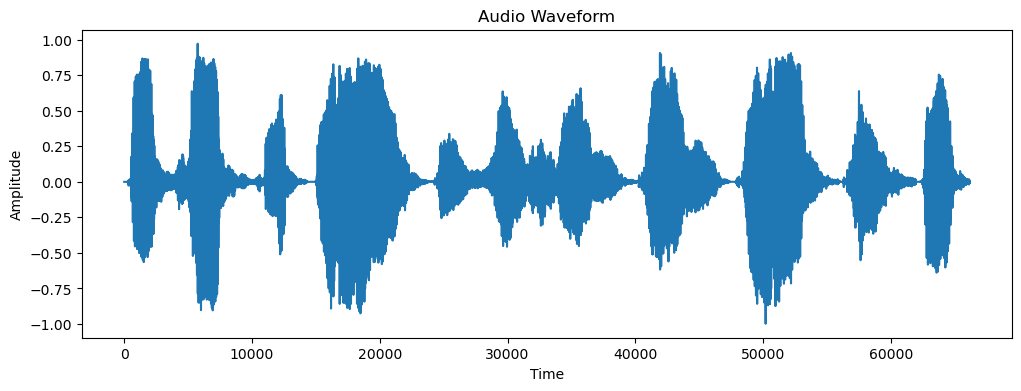

In [29]:

num_display = 4
for i in random.sample(best_signal_reconstruted, number_dic):
    reconstructed_signal = Reconstructor.reconstruct_signal(preprocessed_audios[i])
    print(f"The original signal {i}")
    visualizer = AudioVisualizer(preprocessed_audios[i])
    visualizer.show()
    print(f"The reconstruction version of {i}")
    visualizer = AudioVisualizer(reconstructed_signal)
    visualizer.show()
    print("")
    print("")
    

### Denoising of signal which was part of train set

##### Now we add noises (Dogs voice) to some of those signals (abritrary choising) and using the learned dictionnary to denoise them

In [21]:
noise_adder = NoiseAdder('C:\\Users\\frank\\Online dictionnary learning spard coding\\data\\UrbanSound8K\\UrbanSound8K\\audio\\fold1')

Add different noises to different signals

Original Signal 44


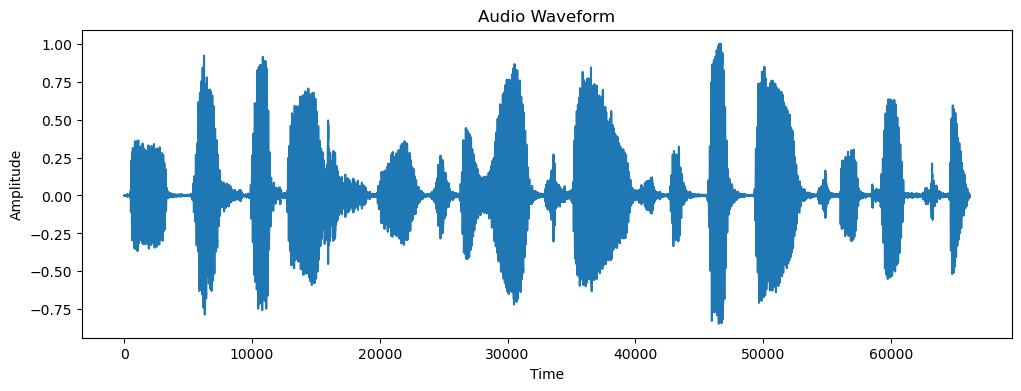

Noised Signal


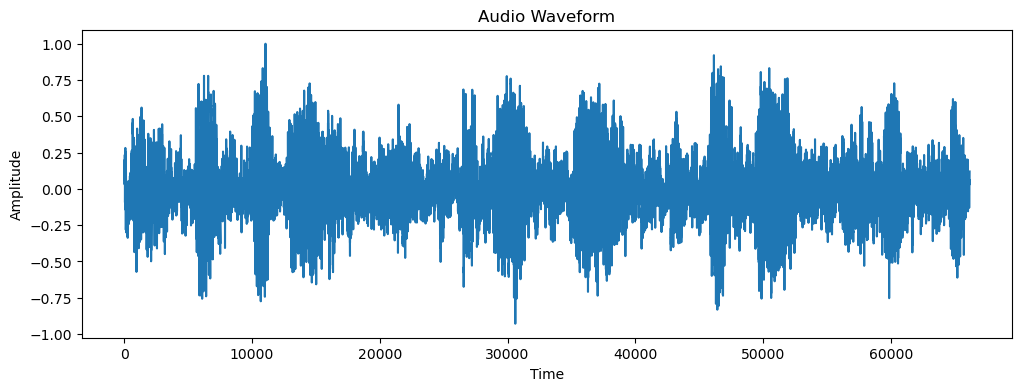

 Reconstructed signal


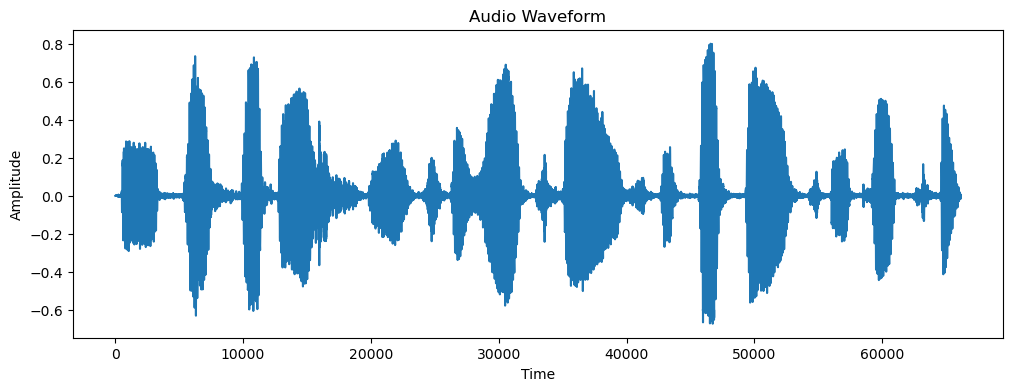



Original Signal 15


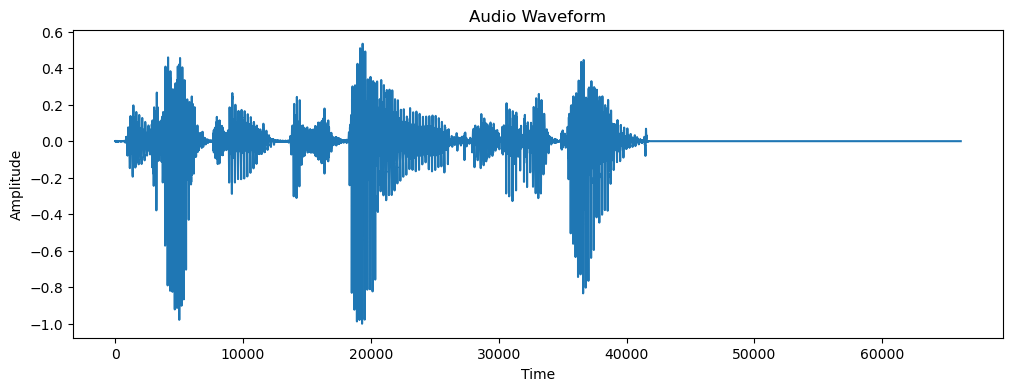

Noised Signal


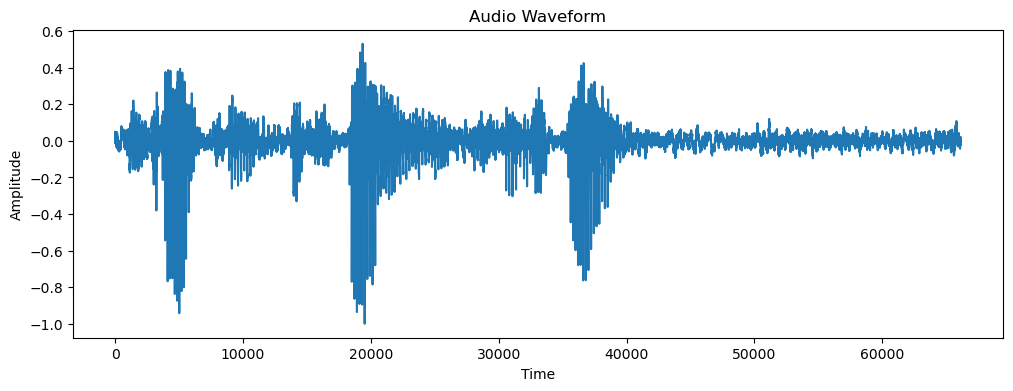

 Reconstructed signal


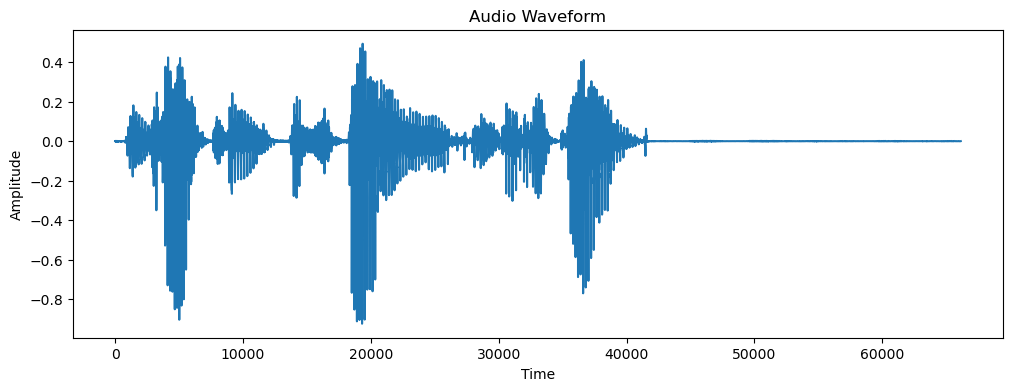



Original Signal 98


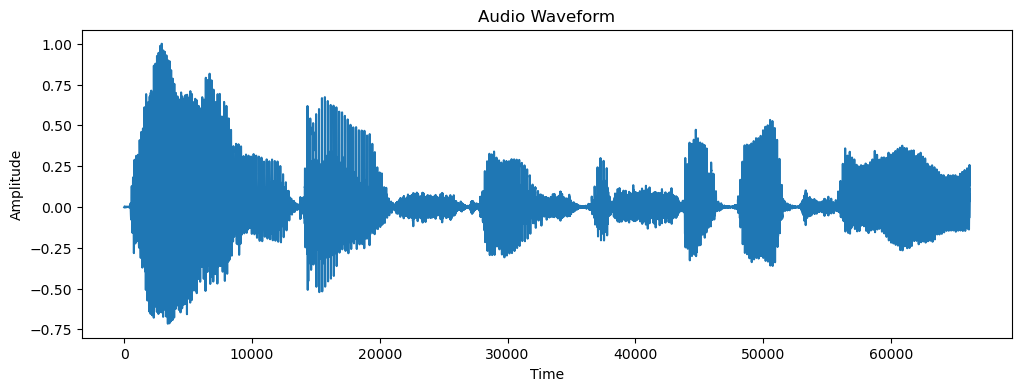

Noised Signal


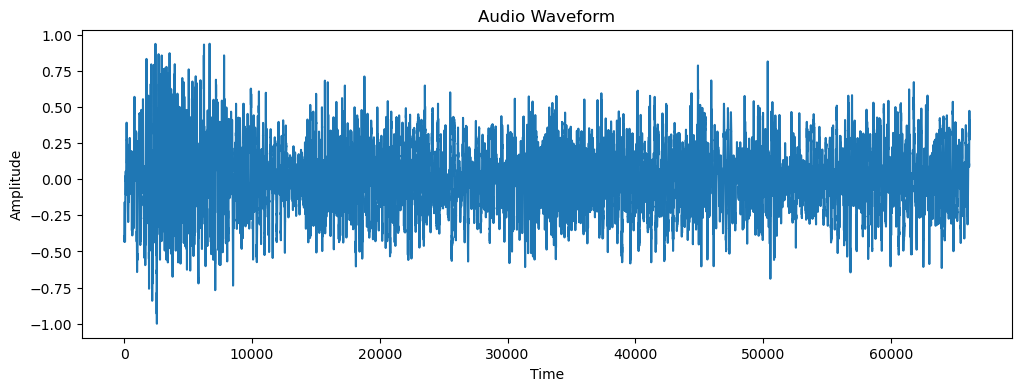

 Reconstructed signal


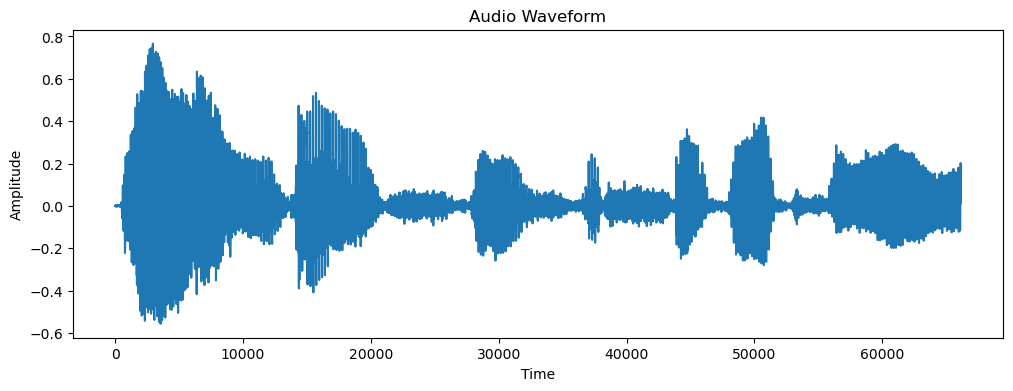



Original Signal 88


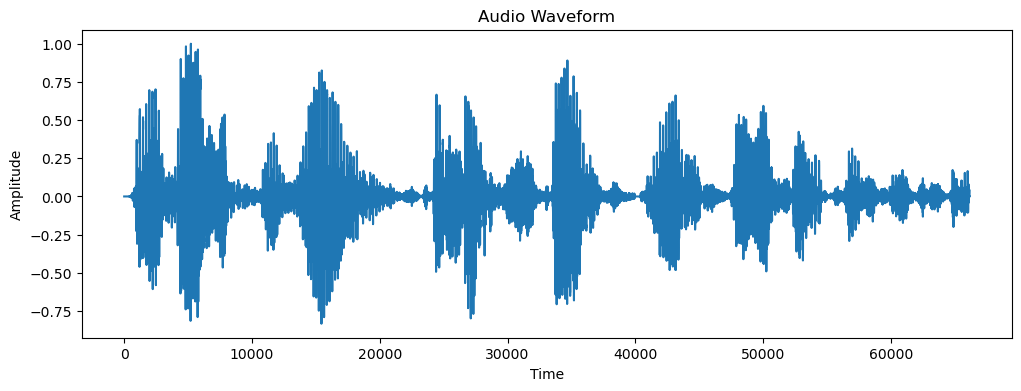

Noised Signal


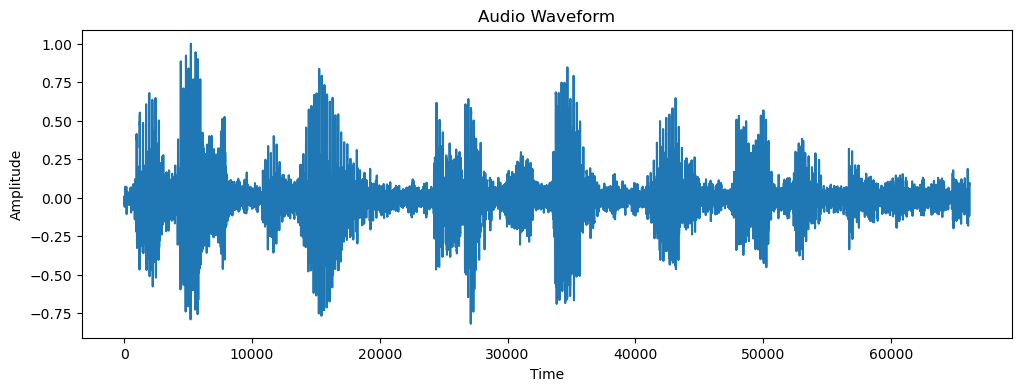

 Reconstructed signal


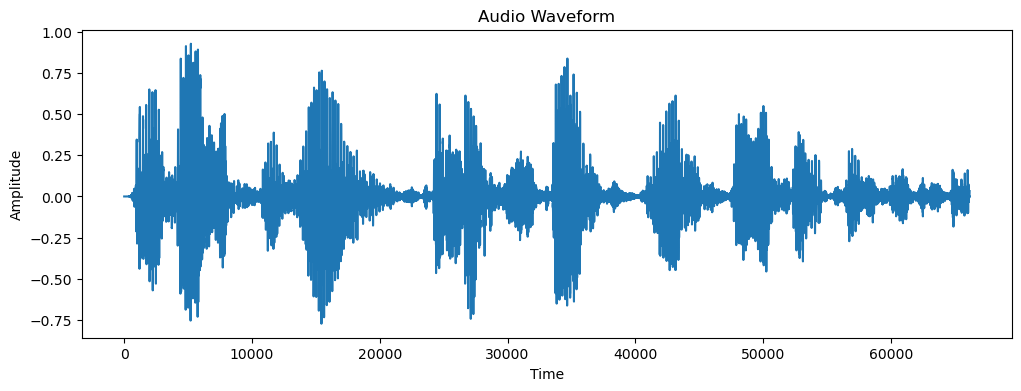

In [27]:
Num_Signal_Add_Noise = 4

for i in random.sample(best_signal_reconstruted, Num_Signal_Add_Noise):
    noised_signal = noise_adder.match_length_and_add_noise(preprocessed_audios[i], sr = None)
    reconstructed_signal = Reconstructor.reconstruct_signal(noised_signal)
    print(f"Original Signal {i}")
    visualizer = AudioVisualizer(preprocessed_audios[i])
    visualizer.show()
    print(f"Noised Signal")
    visualizer = AudioVisualizer(noised_signal)
    visualizer.show()
    print(f" Reconstructed signal")
    visualizer = AudioVisualizer(reconstructed_signal)
    visualizer.show()
    print("")
    print("")

Note that the lenght of the signal (audio) doesn't have any impact on the previous resultats, to see that you can change the parameter **target_duration** when loading the train set